In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
# declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
# use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [7]:
# inspect the databases
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# get a list of column names and types for 1st table
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [10]:
# get a list of column names and types for 2nd table
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# determine the last date in the database

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last Measurement Date: {last_date[0]}")

Last Measurement Date: 2017-08-23


In [13]:
# Calculate the date one year ago from the last data point in the database

year_ago = dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=364)
print ('Start Date:', year_ago)

Start Date: 2016-08-24 00:00:00


In [14]:
# Perform a query to retrieve the date and precipitation scores

data_1_yr = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= year_ago).all()
data_1_yr[:5]

[('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0)]

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(data_1_yr, columns=['Date','Precipitation'])
precip_df = precip_df.set_index("Date")
precip_df.head()

,Precipitation
Date,
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00


In [16]:
# Sort the dataframe by date

precip_df = precip_df.sort_values(["Date"], ascending=True).dropna()
precip_df

,Precipitation
Date,
2016-08-25,0.08
2016-08-25,0.00
2016-08-25,0.06
2016-08-25,0.00
2016-08-25,0.08
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


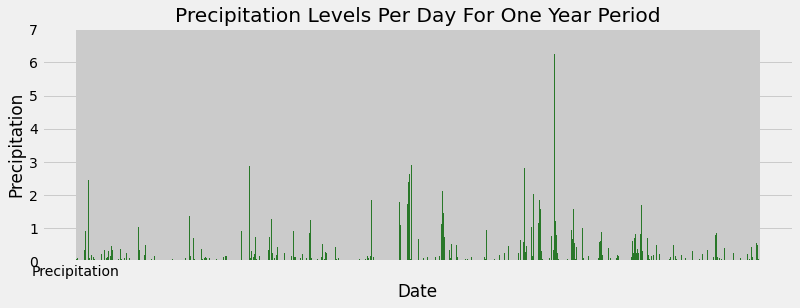

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

y = precip_df["Precipitation"]
x = precip_df
plt.figure(figsize=(12,4))
plt.xticks(np.arange(len(y)), x)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Levels Per Day For One Year Period')
plt.bar(range(len(y)), y, color='darkgreen', alpha=0.8, align="center") 
plt.show()


In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data

precip_df.describe()

,Precipitation
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {station_count} weather stations in the dataset.")

There are 9 weather stations in the dataset.


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

readings_per_station = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
readings_per_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active = readings_per_station[0][0]
most_active

'USC00519281'

In [22]:
temps = [func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]

session.query(*temps).filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_data = session.query(Measurement.tobs).\
                filter(Measurement.date > year_ago).\
                filter(Measurement.station == ('USC00519281').all()

#station_data

station_data_df= pd.DataFrame(station_data)
station_data_df.head()

In [ ]:

plt.hist(station_data_df["tobs"],bins=12, label="tobs")
plt.title("Temperatures for Last 12 Months")
plt.ylabel("Frequency")
plt.xlabel("Temp")
plt.savefig("images/histogram.png")


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
